# Beta Distribution Plots

In [1]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

save_path = Path("plots")
save_path.mkdir(parents=True, exist_ok=True)
sns.set_theme(style="ticks", context="paper", palette="colorblind", font_scale=1.5)

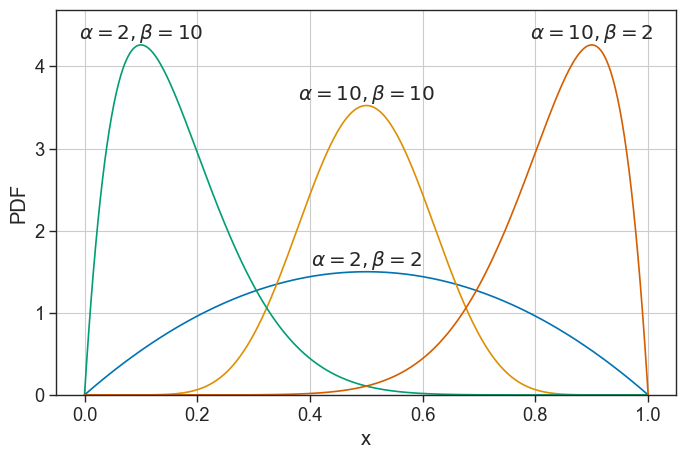

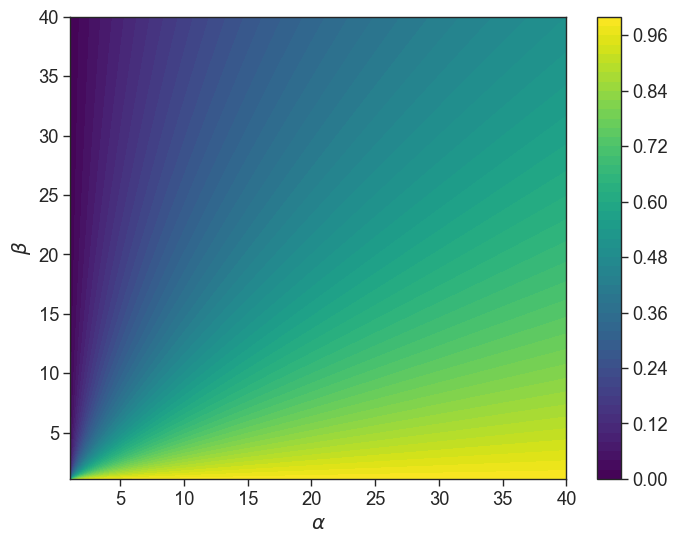

In [4]:
x = np.linspace(0, 1, 500)
params = [(2, 2), (10, 10), (2, 10), (10, 2)]

plt.figure(figsize=(8, 5))
for alpha, beta_param in params:
    if alpha > 1 and beta_param > 1:
        pdf = beta.pdf(x, alpha, beta_param)
        plt.plot(x, pdf)
        # Place the label at the mode of the distribution
        mode_x = (alpha - 1) / (alpha + beta_param - 2)
        mode_y = beta.pdf(mode_x, alpha, beta_param)
        plt.text(
            mode_x,
            mode_y,
            f"$\\alpha={alpha}, \\beta={beta_param}$",
            ha="center",
            va="bottom",
        )
        plt.ylim(0, 1.1 * max(pdf))


plt.ylabel("PDF")
plt.xlabel("x")
plt.grid(True)
plt.savefig(save_path / "PDF.pdf", bbox_inches="tight", dpi=300)

alpha_range = np.linspace(1.1, 40, 1000)
beta_range = np.linspace(1.1, 40, 1000)
A, B = np.meshgrid(alpha_range, beta_range)
mode = (A - 1) / (A + B - 2)

plt.figure(figsize=(8, 6))
cp = plt.contourf(A, B, mode, levels=50, cmap="viridis")
plt.colorbar(cp)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.savefig(save_path / "Mode.pdf", bbox_inches="tight", dpi=300)


# Dilation Comparisons

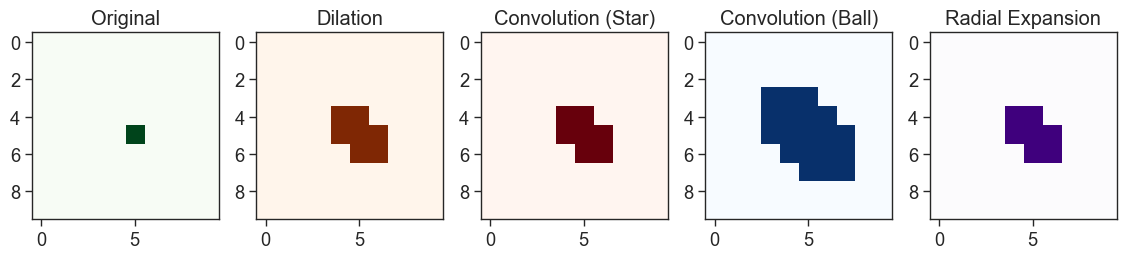

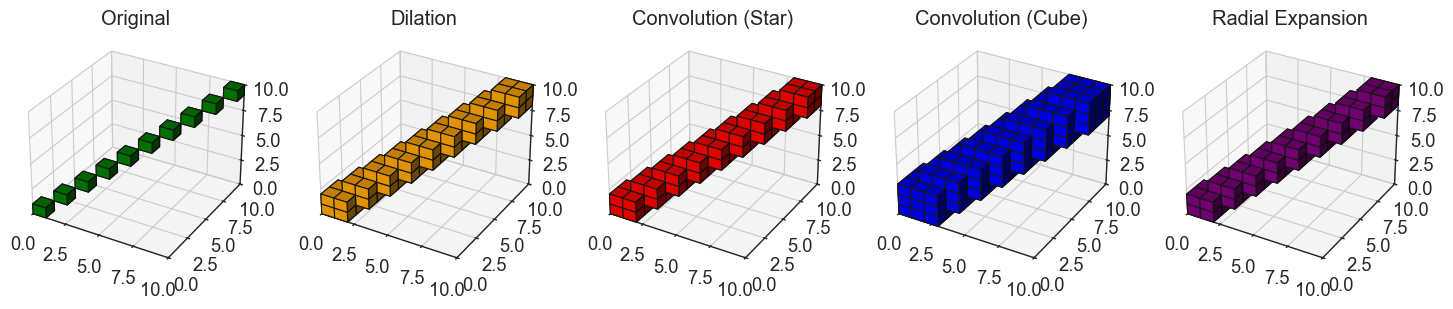

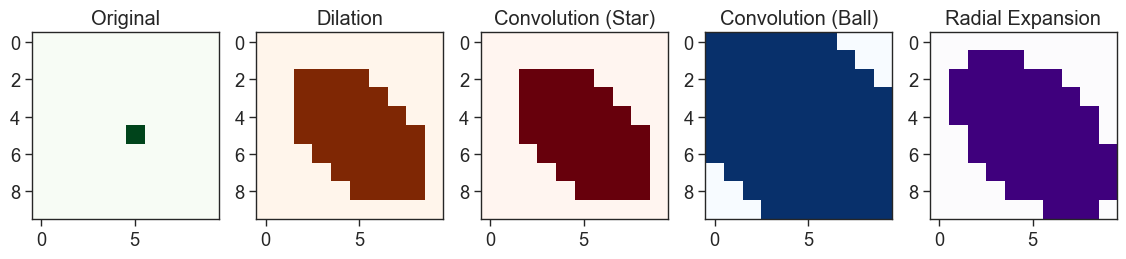

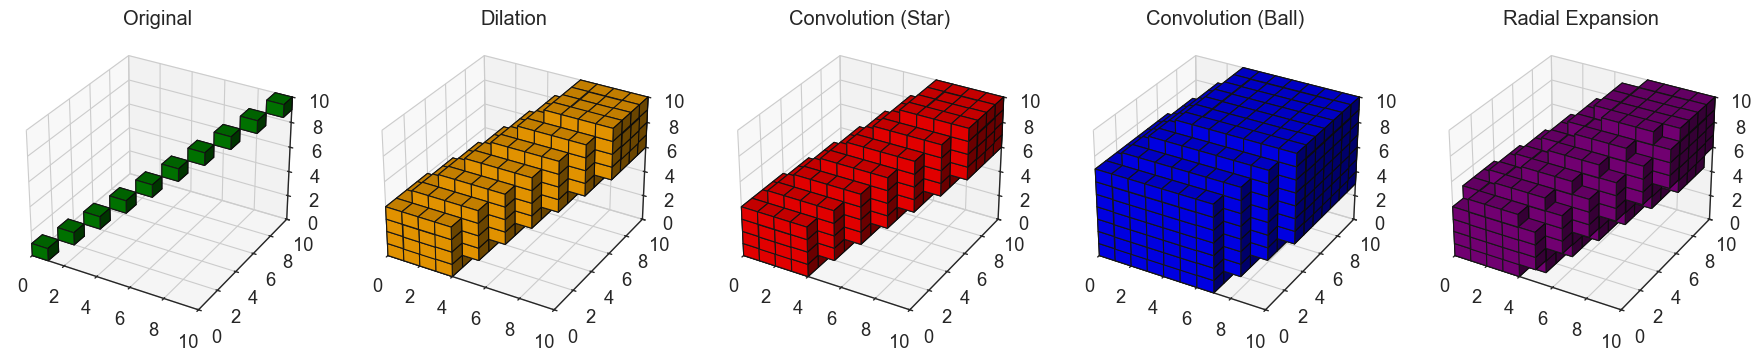

In [8]:
from scipy.ndimage import binary_dilation
import torch
from navigator.utils import BinaryDilation3D, draw_path_sphere_jax
import jax.numpy as jnp
from skimage.draw import line_nd
import matplotlib.pyplot as plt

img = torch.zeros((10, 10, 10), dtype=torch.float32)

line = line_nd((0, 0, 0), (10, 10, 10))
img[line] = 1

dilation_star = BinaryDilation3D("star")
dilation_ball = BinaryDilation3D("cube", kernel_size=3)

dilation_star = dilation_star.to(img.device)
dilation_ball = dilation_ball.to(img.device)

img_star = dilation_star(img.unsqueeze(0).unsqueeze_(0)).squeeze(0).squeeze(0)
img_ball = dilation_ball(img.unsqueeze(0).unsqueeze_(0)).squeeze(0).squeeze(0)

# JAX version
img_jax = jnp.from_dlpack(img, copy=False)
img_jax = draw_path_sphere_jax(img_jax, line, radius=1, fill_value=1)

# Scipy version
img_scipy = binary_dilation(img.cpu().numpy())

# Combined plots (2D)
fig, axs = plt.subplots(1, 5, figsize=(14, 4))
axs[0].imshow(img[5].cpu().numpy(), cmap="Greens")
axs[0].set_title("Original")
axs[1].imshow(img_scipy[5], cmap="Oranges")
axs[1].set_title("Dilation")
axs[2].imshow(img_star[5].cpu().numpy(), cmap="Reds")
axs[2].set_title("Convolution (Star)")
axs[3].imshow(img_ball[5].cpu().numpy(), cmap="Blues")
axs[3].set_title("Convolution (Ball)")
axs[4].imshow(img_jax[5], cmap="Purples")
axs[4].set_title("Radial Expansion")
fig.savefig(save_path / "dilation_comparison_2d.pdf", bbox_inches="tight")

# Combined plots (3D)
# Fix axes to be consistent
fig = plt.figure(figsize=(18, 6))  # Increased figure size for better spacing
ax1 = fig.add_subplot(151, projection="3d")
ax1.voxels(img.cpu().numpy(), facecolors="green", edgecolors="k")
ax1.set_title("Original")
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.set_zlim([0, 10])

ax2 = fig.add_subplot(152, projection="3d")
ax2.voxels(img_scipy, facecolors="orange", edgecolors="k")
ax2.set_title("Dilation")
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.set_zlim([0, 10])

ax3 = fig.add_subplot(153, projection="3d")
ax3.voxels(img_star.cpu().numpy(), facecolors="red", edgecolors="k")
ax3.set_title("Convolution (Star)")
ax3.set_xlim([0, 10])
ax3.set_ylim([0, 10])
ax3.set_zlim([0, 10])

ax4 = fig.add_subplot(154, projection="3d")
ax4.voxels(img_ball.cpu().numpy(), facecolors="blue", edgecolors="k")
ax4.set_title("Convolution (Cube)")
ax4.set_xlim([0, 10])
ax4.set_ylim([0, 10])
ax4.set_zlim([0, 10])


ax5 = fig.add_subplot(155, projection="3d")
ax5.voxels(img_jax, facecolors="purple", edgecolors="k")
ax5.set_title("Radial Expansion")
ax5.set_xlim([0, 10])
ax5.set_ylim([0, 10])
ax5.set_zlim([0, 10])
fig.savefig(save_path / "dilation_comparison_3d.pdf", bbox_inches="tight")

# Now with repeated dilation
dilation_ball_repeated = torch.nn.Sequential(*[BinaryDilation3D("cube", 3)] * 3)
img_ball_repeated = dilation_ball_repeated(img.unsqueeze(0).unsqueeze_(0)).squeeze(0).squeeze(0)

img_jax_repeated = draw_path_sphere_jax(img_jax, line, radius=3, fill_value=1)
dilation_star_repeated = torch.nn.Sequential(*[BinaryDilation3D("star")] * 3)
img_star_repeated = dilation_star_repeated(img.unsqueeze(0).unsqueeze_(0)).squeeze(0).squeeze(0)
scipy_dilation_repeated = binary_dilation(img.cpu().numpy(), iterations=3)

# 2D
fig, axs = plt.subplots(1, 5, figsize=(14, 4))  # Increased figure size for better spacing
axs[0].imshow(img[5].cpu().numpy(), cmap="Greens")
axs[0].set_title("Original")
axs[0].set_aspect("equal", adjustable="box")

axs[1].imshow(scipy_dilation_repeated[5], cmap="Oranges")
axs[1].set_title("Dilation")
axs[1].set_aspect("equal", adjustable="box")

axs[2].imshow(img_star_repeated[5].cpu().numpy(), cmap="Reds")
axs[2].set_title("Convolution (Star)")
axs[2].set_aspect("equal", adjustable="box")
axs[3].imshow(img_ball_repeated[5].cpu().numpy(), cmap="Blues")
axs[3].set_title("Convolution (Ball)")
axs[3].set_aspect("equal", adjustable="box")
axs[4].imshow(img_jax_repeated[5], cmap="Purples")
axs[4].set_title("Radial Expansion")
axs[4].set_aspect("equal", adjustable="box")
fig.savefig(save_path / "dilation_comparison_repeated_2d.pdf", bbox_inches="tight")
# 3D
fig = plt.figure(figsize=(18, 6))  # Increased figure size for better spacing
ax1 = fig.add_subplot(151, projection="3d")
ax1.voxels(img.cpu().numpy(), facecolors="green", edgecolors="k")
ax1.set_title("Original")
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])
ax1.set_zlim([0, 10])

ax2 = fig.add_subplot(152, projection="3d")
ax2.voxels(scipy_dilation_repeated, facecolors="orange", edgecolors="k")
ax2.set_title("Dilation")
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.set_zlim([0, 10])
ax3 = fig.add_subplot(153, projection="3d")
ax3.voxels(img_star_repeated.cpu().numpy(), facecolors="red", edgecolors="k")
ax3.set_title("Convolution (Star)")
ax3.set_xlim([0, 10])
ax3.set_ylim([0, 10])
ax3.set_zlim([0, 10])
ax4 = fig.add_subplot(154, projection="3d")
ax4.voxels(img_ball_repeated.cpu().numpy(), facecolors="blue", edgecolors="k")
ax4.set_title("Convolution (Ball)")
ax4.set_xlim([0, 10])
ax4.set_ylim([0, 10])
ax4.set_zlim([0, 10])
ax5 = fig.add_subplot(155, projection="3d")
ax5.voxels(img_jax_repeated, facecolors="purple", edgecolors="k")
ax5.set_title("Radial Expansion")
ax5.set_xlim([0, 10])
ax5.set_ylim([0, 10])
ax5.set_zlim([0, 10])
fig.savefig(save_path / "dilation_comparison_repeated_3d.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


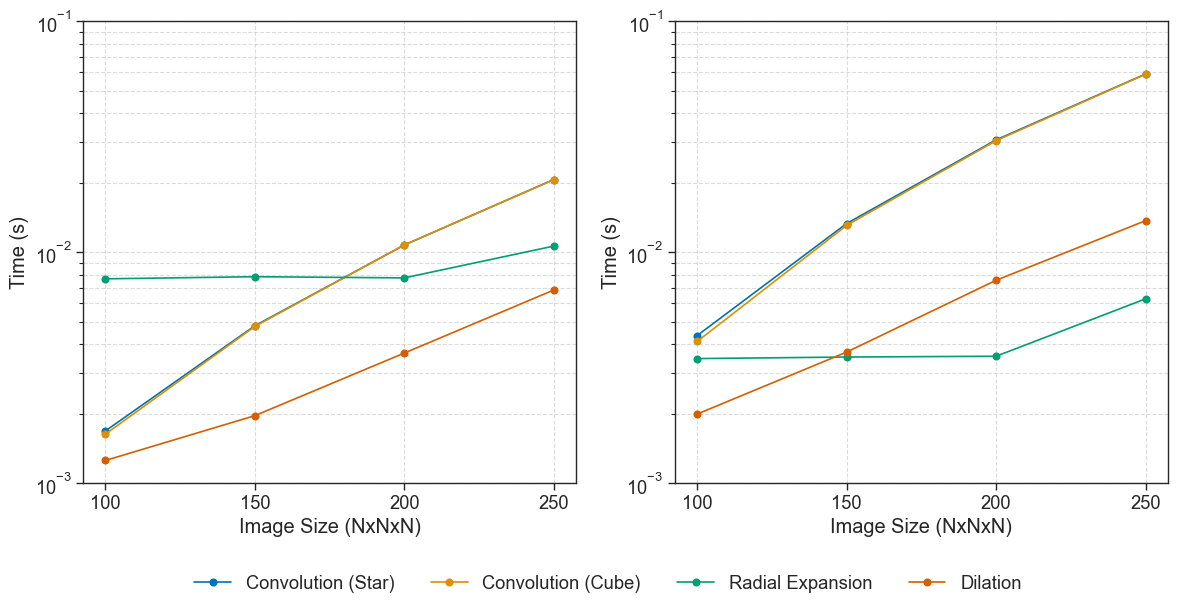

In [20]:
from io import StringIO
import pandas as pd

repeated_csv = """Size,Star Dilation Time,Ball Dilation Time,JAX Dilation Time,Scipy Dilation Time
100x100x100,0.004356,0.004107,0.003462,0.001992
150x150x150,0.013305,0.01306,0.003516,0.003694
200x200x200,0.030628,0.030387,0.003544,0.007558
250x250x250,0.05906,0.058907,0.006279,0.013686
"""

nonrepeated_csv = """Size,Star Dilation Time,Ball Dilation Time,JAX Dilation Time,Scipy Dilation Time
100x100x100,0.001683,0.00163,0.007667,0.001254
150x150x150,0.004801,0.004768,0.00783,0.00196
200x200x200,0.010737,0.010746,0.007738,0.003658
250x250x250,0.020628,0.02059,0.010624,0.006856
"""

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
df_nonrepeated = pd.read_csv(StringIO(nonrepeated_csv))
df_repeated = pd.read_csv(StringIO(repeated_csv))

# Extract numerical size from the 'Size' column
df_nonrepeated["Size_Numeric"] = df_nonrepeated["Size"].apply(lambda x: int(x.split("x")[0]))
df_repeated["Size_Numeric"] = df_repeated["Size"].apply(lambda x: int(x.split("x")[0]))

# Set 'Size_Numeric' as index for easier plotting
df_nonrepeated = df_nonrepeated.set_index("Size_Numeric")
df_repeated = df_repeated.set_index("Size_Numeric")

# Define the columns to plot (excluding 'Size' and 'Size_Numeric')
plot_columns = [col for col in df_nonrepeated.columns if col not in ["Size", "Size_Numeric"]]
label_map = {
    "Scipy Dilation Time": "Dilation",
    "Star Dilation Time": "Convolution (Star)",
    "Ball Dilation Time": "Convolution (Cube)",
    "JAX Dilation Time": "Radial Expansion",
}

handles = []
for i, (ax, df) in enumerate(zip(axs, [df_nonrepeated, df_repeated])):
    df.title = "Non-Repeated Dilation Times" if i == 0 else "Repeated Dilation Times"
    for col in plot_columns:
        label = label_map.get(col, col.replace(" Time", ""))
        (line,) = ax.plot(df.index, df[col], marker="o", label=label)
        handles.append(line)
    ax.set_xlabel("Image Size (NxNxN)")
    ax.set_ylabel("Time (s)")  # Indicate log scale in label
    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", alpha=0.7)
    ax.set_yticks([1e-3, 1e-2, 1e-1])
    ax.set_xticks([100, 150, 200, 250])

fig.legend(
    handles=handles[:4], loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.1), frameon=False
)
plt.savefig(save_path / "dilation_times_plot.pdf", bbox_inches="tight")
plt.show()